In [4]:
""" General imports"""
import os
from glob import glob
import pickle
import itertools
import numpy as np
from scipy.stats import zscore
import sys
from tqdm import tqdm
import pandas as pd
### Graph imports ###
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from IPython.display import Image as Imag
### Audio import ###
import librosa
import IPython
from IPython.display import Audio

### import machine learning and deep learning libraries

In [2]:
# Machine learning
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss, hinge_loss
from sklearn.preprocessing import Normalizer , scale, LabelEncoder, StandardScaler

In [7]:
### Time Distributed ConvNet imports ###
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from keras.regularizers import L2
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate, LSTM, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv3D, MaxPool3D, ConvLSTM3D, MaxPooling3D, AveragePooling3D, ZeroPadding3D, Convolution3D
from tensorflow.keras.layers import Conv2D, MaxPool2D, ConvLSTM2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.models import Sequential, Model, load_model,  model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [8]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


#
----
# **RAVDESS**
---
#

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [5]:
# Define emotion mapping
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'}

In [6]:
""" Step 1: Build metadata DataFrame """

file_path = '/kaggle/input/ravdess/ravdess/'
data = []
for speaker_folder in os.listdir(file_path):
    speaker_path = os.path.join(file_path, speaker_folder)
    if not os.path.isdir(speaker_path):
        continue
    for audio_file in os.listdir(speaker_path):
        if audio_file.endswith('.wav'):
            emotion = audio_file.split('_')[1]  
            spk = audio_file.split('_')[0]
            if emotion:
                data.append({
                    'filepath': os.path.join(speaker_path, audio_file),
                    'speaker_id': spk,
                    'emotion': emotion})

In [8]:
df = pd.DataFrame(data)
df

,filepath,speaker_id,emotion
0,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,calm
1,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,calm
2,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,surprised
3,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,disgust
4,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,angry
...,...,...,...
1435,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,fearful
1436,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,surprised
1437,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,surprised
1438,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,neutral


# Original dataset

<Figure size 2000x500 with 0 Axes>

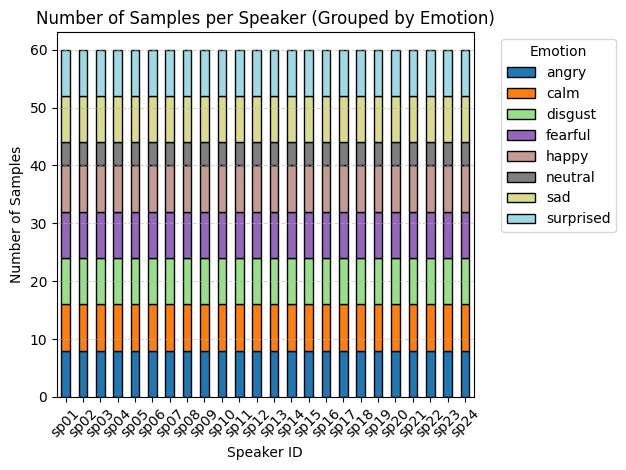

In [9]:
""" Count samples per speaker and emotion"""

counts = df.groupby(['speaker_id', 'emotion']).size().unstack(fill_value=0)
########################################
plt.figure(figsize=(20, 5))
counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title('Number of Samples per Speaker (Grouped by Emotion)')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [10]:
""" Count number of samples per (speaker, emotion) pair"""
counts = df.groupby(['speaker_id', 'emotion']).size().reset_index(name='count')

""" Filter problematic ones"""
rare_combos = counts[counts['count'] < 2]
print(rare_combos)

Empty DataFrame
Columns: [speaker_id, emotion, count]
Index: []


In [11]:
""" Merge counts back to df"""
df = df.merge(counts, on=['speaker_id', 'emotion'])

""" Keep only those with at least 2 samples"""
df = df[df['count'] >= 2].drop(columns=['count'])

In [12]:
df['stratify'] = df['speaker_id'] + "_" + df['emotion']
df

,filepath,speaker_id,emotion,stratify
0,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,calm,sp02_calm
1,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,calm,sp02_calm
2,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,surprised,sp02_surprised
3,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,disgust,sp02_disgust
4,/kaggle/input/ravdess/ravdess/train/Actor_02/s...,sp02,angry,sp02_angry
...,...,...,...,...
1435,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,fearful,sp07_fearful
1436,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,surprised,sp07_surprised
1437,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,surprised,sp07_surprised
1438,/kaggle/input/ravdess/ravdess/test/Actor_07/sp...,sp07,neutral,sp07_neutral


# load signals

In [14]:
def load_signal(filepath, max_len=64000, augment=True, sr=16000):
    frames = []
    y, sr = librosa.load(filepath, sr=sr)
    vad = librosa.effects.split(y, top_db=30)
    y = y[vad[0][0]:vad[-1][1]]
    if len(y) > 16000:
        if len(y) > max_len:
            y = y[:max_len]
            frames.append(y) 
        else:
            frames.append(y) 
    return frames

In [15]:
""" load signals """
X = []
y = []
emo = []
print("Processing training files...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    frames = load_signal(row['filepath'], augment=True)
    for f in frames:
        X.append(f)
        y.append(row['speaker_id'])  # speaker label
        emo.append(row['emotion'])  # speaker label

Processing training files...


100%|██████████| 1440/1440 [00:22<00:00, 63.11it/s]


<Figure size 2000x500 with 0 Axes>

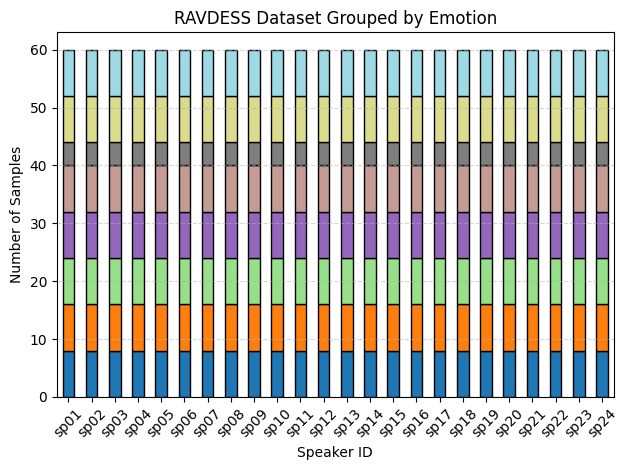

In [17]:
df_fold = pd.DataFrame({'speaker_id': y,'emotion': emo})

"""Pivot to count samples per speaker per emotion"""
counts = df_fold.groupby(['speaker_id', 'emotion']).size().unstack(fill_value=0)
########################################

plt.figure(figsize=(20, 5))
counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
plt.title(f'RAVDESS Dataset Grouped by Emotion')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend().remove()  
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

---
# **Split to 4 folds**
---

In [18]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

y = np.array(y) 
emo = np.array(emo)    
########################################
dfr = pd.DataFrame({
    'index': np.arange(len(X)),
    'speaker_id': y,
    'emotion': emo})
########################################
n_splits = 4
fold_names = ['a', 'b', 'c', 'd']
folds = defaultdict(list)
########################################
for speaker_id, user_df in dfr.groupby('speaker_id'):
    if len(user_df['emotion'].unique()) == 1 or len(user_df) < n_splits:
        """ Not enough data or only one class → random split instead"""
        shuffled = user_df.sample(frac=1, random_state=42)
        chunks = np.array_split(shuffled['index'].values, n_splits)
        for i, chunk in enumerate(chunks):
            folds[fold_names[i]].extend(chunk)
    else:
        """ Proper stratified split per user"""
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for i, (_, val_idx) in enumerate(skf.split(user_df['index'], user_df['emotion'])):
            fold_name = fold_names[i]
            selected_indices = user_df.iloc[val_idx]['index'].values
            folds[fold_name].extend(selected_indices)
########################################
""" Step 4: Create fold_data dictionary"""
fold_data = {}
for name in fold_names:
    val_idx = np.array(folds[name])
    train_idx = np.setdiff1d(np.arange(len(X)), val_idx)
    fold_data[name] = {
        'y_train': y[train_idx],
        'emo_train': emo[train_idx],
        'y_val': y[val_idx],
        'emo_val': emo[val_idx]}

<Figure size 2000x500 with 0 Axes>

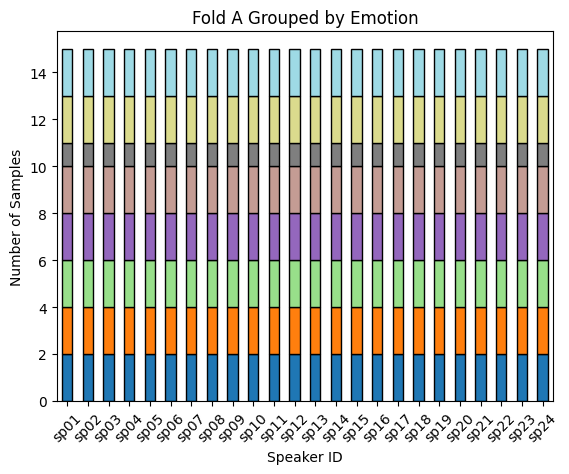

<Figure size 2000x500 with 0 Axes>

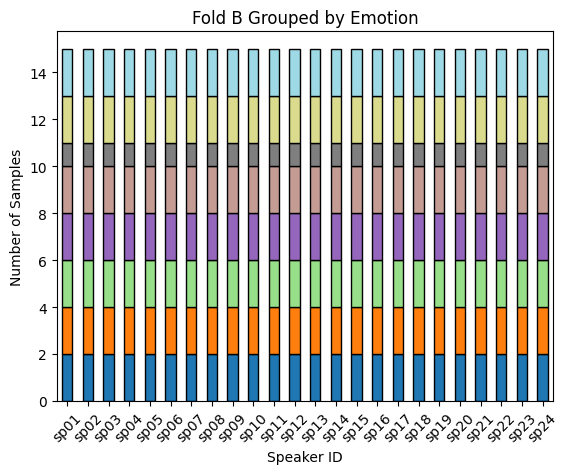

<Figure size 2000x500 with 0 Axes>

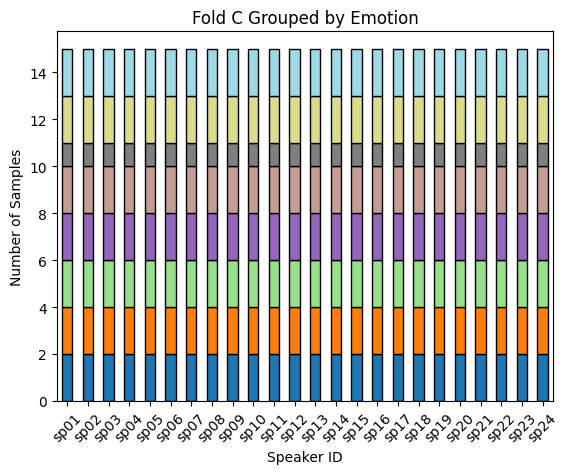

<Figure size 2000x500 with 0 Axes>

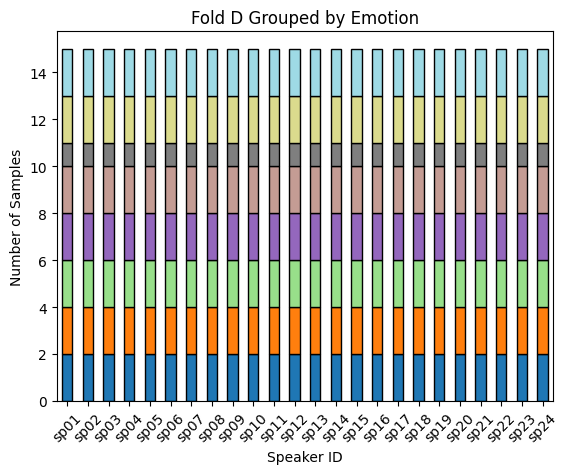

In [19]:
""" Loop over each fold"""
for fold_name in fold_data:
    y_val = fold_data[fold_name]['y_val']
    emo_val = fold_data[fold_name]['emo_val']
    df_fold = pd.DataFrame({
        'speaker_id': y_val,
        'emotion': emo_val})
    ########################################
    counts = df_fold.groupby(['speaker_id', 'emotion']).size().unstack(fill_value=0)
    plt.figure(figsize=(20, 5))
    counts.plot(kind='bar', stacked=True, colormap='tab20', edgecolor='black')
    plt.title(f'Fold {fold_name.upper()} Grouped by Emotion')
    plt.xlabel('Speaker ID')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.legend().remove() 
    plt.show()

# processing functions

In [20]:
""" functions for extracting spectrogram and frame it""" 

def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128,
                    window='hamming', n_mels=64, fmax=8000):
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window,
                                     win_length=win_length,
                                     hop_length=hop_length)) ** 2
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr,
                                                n_mels=n_mels, fmax=fmax)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    return mel_spect

def frame(x, max_frames=8, win_size=64):
    win_step = (x.shape[1] - win_size) // (max_frames - 1)
    win_step = max(win_step, 1)
    frames = np.zeros((max_frames, x.shape[0], win_size)).astype(np.float32)
    start = 0
    for t in range(max_frames):
        frames[t, :, :] = x[:, start:start + win_size].astype(np.float32)
        start += win_step
    return frames

In [21]:
""" data augmentation functions"""
"""noise"""
def noisy_signal(signal, snr_low=15, snr_high=30):
    signal_len = len(signal)
    noise = np.random.normal(size=signal_len)
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2) / signal_len
    snr = np.random.randint(snr_low, snr_high)
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    return signal + K * noise

""" Pitch shift function"""
def pitch_shift(signal, sr, n_steps=0.25):  
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)
"""Time stretch function"""
def time_stretch(signal): 
    return librosa.effects.time_stretch(signal, rate = 0.9)
def speed_change(signal): 
    return librosa.effects.time_stretch(signal, rate = 1.2)
"""Time shift function"""
def time_shift(signal, shift_max=0.2):
    shift = np.random.randint(len(signal) * shift_max)
    return np.roll(signal, shift)

In [22]:
def apply_augmentations(y, sr=16000):
    augmented_signals = []
    # Add original signal
    augmented_signals.append(y)
    Add noise
    y_noise = noisy_signal(y)
    augmented_signals.append(y_noise)
    # Pitch shift
    y_pitch = pitch_shift(y, sr=sr, n_steps=0.25)
    augmented_signals.append(y_pitch)
    # Time stretch (only if length < 57935)
    if len(y) < 57935:
        try:
            y_stretch = time_stretch(y)
            augmented_signals.append(y_stretch)
        except:
            pass
    # Speed up (only if length > 19200)
    if len(y) > 19200:
        try:
            y_speed = speed_change(y)
            augmented_signals.append(y_speed)
        except:
            pass
    # Time shift
    y_shift = time_shift(y)
    augmented_signals.append(y_shift)
    return augmented_signals

In [23]:
def process_and_augment(filepath, max_len=64000, augment=True, sr=16000):
    y, sr = librosa.load(filepath, sr=sr)
    vad = librosa.effects.split(y, top_db=30)
    y = y[vad[0][0]:vad[-1][1]]
    if len(y) > 16000:
        if len(y) > max_len:
            y = y[:max_len]
        frames = []
        signals = apply_augmentations(y, sr=sr) if augment else [y]
        for signal in signals:
            if len(signal) > max_len:
                signal = signal[:max_len]
            elif len(signal) < max_len:
                signal = np.pad(signal, (0, max_len - len(signal)))
            spec = mel_spectrogram(signal, sr=sr)
            frames.append(frame(spec)) 
        return frames
    return []

---
# **LOAD ORIGINAL DATA FOR EACH FOLD**
---

In [24]:
df = pd.DataFrame(data)
original_folds = {}
for fold_name in fold_names:
    print(f"\nProcessing original fold: {fold_name}")
    fold_idx = np.array(folds[fold_name])
    fold_df = df.iloc[fold_idx]
    X_fold = []
    y_fold = []
    emo_fold = []
    for _, row in tqdm(fold_df.iterrows(), total=len(fold_df)):
        # Apply augmentations and extract features
        frames = process_and_augment(row['filepath'], augment=False)
        for f in frames:
            X_fold.append(f)
            y_fold.append(row['speaker_id'])
            emo_fold.append(row['emotion'])
    # Convert to numpy arrays
    X_fold = np.array(X_fold)
    y_fold = np.array(y_fold)
    emo_fold = np.array(emo_fold)
    # Save into the dict
    original_folds[fold_name] = {
        'X': X_fold,          # shape: (n_augmented, 8, 64, 64)
        'y': y_fold,          # speaker labels
        'emo': emo_fold}       # emotion labels


Processing original fold: a


100%|██████████| 360/360 [00:03<00:00, 101.00it/s]



Processing original fold: b


100%|██████████| 360/360 [00:03<00:00, 100.69it/s]



Processing original fold: c


100%|██████████| 360/360 [00:03<00:00, 104.17it/s]



Processing original fold: d


100%|██████████| 360/360 [00:03<00:00, 101.60it/s]


In [25]:
for fold_name in fold_names:
    n_samples = len(original_folds[fold_name]['X'])
    print(f"Fold {fold_name}: {n_samples} augmented samples")

Fold a: 360 augmented samples
Fold b: 360 augmented samples
Fold c: 360 augmented samples
Fold d: 360 augmented samples


In [52]:
for fold_name in fold_names:
    print(f"\nFold {fold_name}:")
    y = original_folds[fold_name]['y']
    emo = original_folds[fold_name]['emo']
    df_fold = pd.DataFrame({'speaker_id': y, 'emotion': emo})
    
    # Count per speaker
    speaker_counts = df_fold['speaker_id'].value_counts().sort_index()
    print("Samples per speaker:")
    print(speaker_counts)
    
    # Count per emotion
    emotion_counts = df_fold['emotion'].value_counts().sort_index()
    print("\nSamples per emotion:")
    print(emotion_counts)


Fold a:
Samples per speaker:
speaker_id
sp01    15
sp02    15
sp03    15
sp04    15
sp05    15
sp06    15
sp07    15
sp08    15
sp09    15
sp10    15
sp11    15
sp12    15
sp13    15
sp14    15
sp15    15
sp16    15
sp17    15
sp18    15
sp19    15
sp20    15
sp21    15
sp22    15
sp23    15
sp24    15
Name: count, dtype: int64

Samples per emotion:
emotion
angry        48
calm         48
disgust      48
fearful      48
happy        48
neutral      24
sad          48
surprised    48
Name: count, dtype: int64

Fold b:
Samples per speaker:
speaker_id
sp01    15
sp02    15
sp03    15
sp04    15
sp05    15
sp06    15
sp07    15
sp08    15
sp09    15
sp10    15
sp11    15
sp12    15
sp13    15
sp14    15
sp15    15
sp16    15
sp17    15
sp18    15
sp19    15
sp20    15
sp21    15
sp22    15
sp23    15
sp24    15
Name: count, dtype: int64

Samples per emotion:
emotion
angry        48
calm         48
disgust      48
fearful      48
happy        48
neutral      24
sad          48
surprised   

In [26]:
summary = []
for fold_name in fold_names:
    n_samples = len(original_folds[fold_name]['X'])
    n_speakers = len(set(original_folds[fold_name]['y']))
    n_emotions = len(set(original_folds[fold_name]['emo']))
    summary.append([fold_name, n_samples, n_speakers, n_emotions])

import pandas as pd
summary_df = pd.DataFrame(summary, columns=["Fold", "Total Samples", "Unique Speakers", "Unique Emotions"])
print(summary_df)

  Fold  Total Samples  Unique Speakers  Unique Emotions
0    a            360               24                8
1    b            360               24                8
2    c            360               24                8
3    d            360               24                8


In [44]:
from time import sleep  # correct import

num_classes = len(label_encoder.classes_)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 15

# **AUGMENTING EACH FOLD INDIVIDUALY**

In [27]:
df = pd.DataFrame(data)
augmented_folds = {}
for fold_name in fold_names:
    print(f"\nProcessing and augmenting fold: {fold_name}")
    fold_idx = np.array(folds[fold_name])
    fold_df = df.iloc[fold_idx]
    X_fold = []
    y_fold = []
    emo_fold = []
    for _, row in tqdm(fold_df.iterrows(), total=len(fold_df)):
        # Apply augmentations and extract features
        frames = process_and_augment(row['filepath'], augment=True)
        for f in frames:
            X_fold.append(f)
            y_fold.append(row['speaker_id'])
            emo_fold.append(row['emotion'])
    # Convert to numpy arrays
    X_fold = np.array(X_fold)
    y_fold = np.array(y_fold)
    emo_fold = np.array(emo_fold)
    # Save into the dict
    augmented_folds[fold_name] = {
        'X': X_fold,          # shape: (n_augmented, 8, 64, 64)
        'y': y_fold,          # speaker labels
        'emo': emo_fold}       # emotion labels


Processing and augmenting fold: a


100%|██████████| 360/360 [00:23<00:00, 15.21it/s]



Processing and augmenting fold: b


100%|██████████| 360/360 [00:23<00:00, 15.27it/s]



Processing and augmenting fold: c


100%|██████████| 360/360 [00:22<00:00, 15.72it/s]



Processing and augmenting fold: d


100%|██████████| 360/360 [00:23<00:00, 15.56it/s]


In [28]:
for fold_name in fold_names:
    n_samples = len(augmented_folds[fold_name]['X'])
    print(f"Fold {fold_name}: {n_samples} augmented samples")

Fold a: 2159 augmented samples
Fold b: 2156 augmented samples
Fold c: 2158 augmented samples
Fold d: 2157 augmented samples


In [50]:
for fold_name in fold_names:
    print(f"\nFold {fold_name}:")
    y = augmented_folds[fold_name]['y']
    emo = augmented_folds[fold_name]['emo']
    df_fold = pd.DataFrame({'speaker_id': y, 'emotion': emo})
    
    # Count per speaker
    speaker_counts = df_fold['speaker_id'].value_counts().sort_index()
    print("Samples per speaker:")
    print(speaker_counts)
    
    # Count per emotion
    emotion_counts = df_fold['emotion'].value_counts().sort_index()
    print("\nSamples per emotion:")
    print(emotion_counts)


Fold a:
Samples per speaker:
speaker_id
sp01    90
sp02    90
sp03    90
sp04    90
sp05    90
sp06    90
sp07    90
sp08    90
sp09    90
sp10    90
sp11    90
sp12    90
sp13    89
sp14    90
sp15    90
sp16    90
sp17    90
sp18    90
sp19    90
sp20    90
sp21    90
sp22    90
sp23    90
sp24    90
Name: count, dtype: int64

Samples per emotion:
emotion
angry        288
calm         287
disgust      288
fearful      288
happy        288
neutral      144
sad          288
surprised    288
Name: count, dtype: int64

Fold b:
Samples per speaker:
speaker_id
sp01    90
sp02    90
sp03    90
sp04    90
sp05    90
sp06    90
sp07    90
sp08    90
sp09    90
sp10    90
sp11    88
sp12    90
sp13    89
sp14    90
sp15    90
sp16    90
sp17    90
sp18    90
sp19    89
sp20    90
sp21    90
sp22    90
sp23    90
sp24    90
Name: count, dtype: int64

Samples per emotion:
emotion
angry        288
calm         287
disgust      287
fearful      288
happy        288
neutral      144
sad          2

In [29]:
summary = []
for fold_name in fold_names:
    n_samples = len(augmented_folds[fold_name]['X'])
    n_speakers = len(set(augmented_folds[fold_name]['y']))
    n_emotions = len(set(augmented_folds[fold_name]['emo']))
    summary.append([fold_name, n_samples, n_speakers, n_emotions])

import pandas as pd
summary_df = pd.DataFrame(summary, columns=["Fold", "Total Samples", "Unique Speakers", "Unique Emotions"])
print(summary_df)

  Fold  Total Samples  Unique Speakers  Unique Emotions
0    a           2159               24                8
1    b           2156               24                8
2    c           2158               24                8
3    d           2157               24                8


<Figure size 2000x500 with 0 Axes>

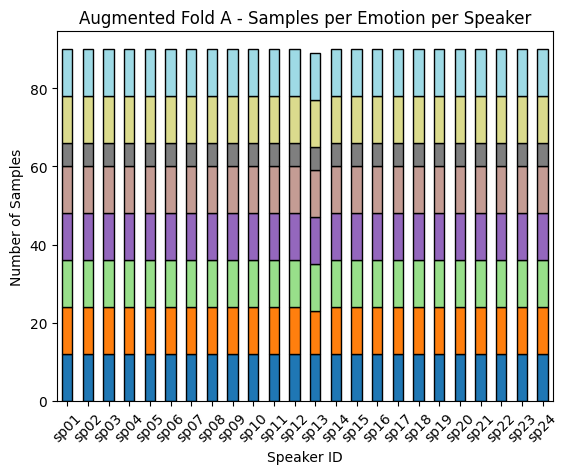

<Figure size 2000x500 with 0 Axes>

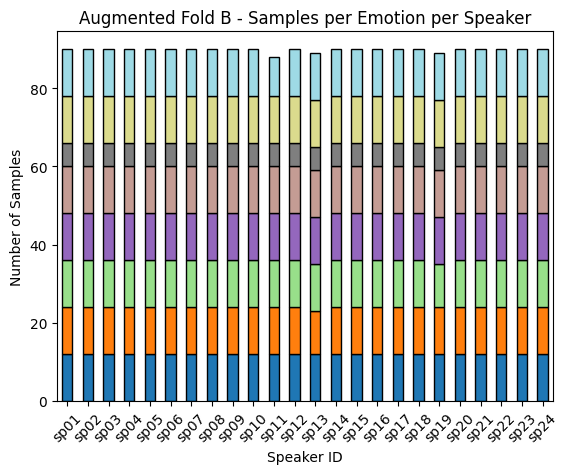

<Figure size 2000x500 with 0 Axes>

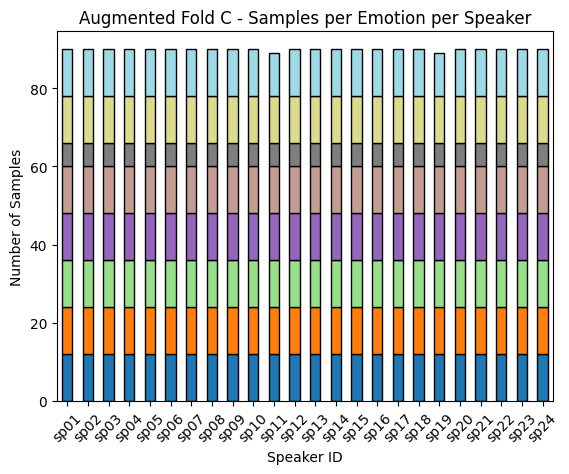

<Figure size 2000x500 with 0 Axes>

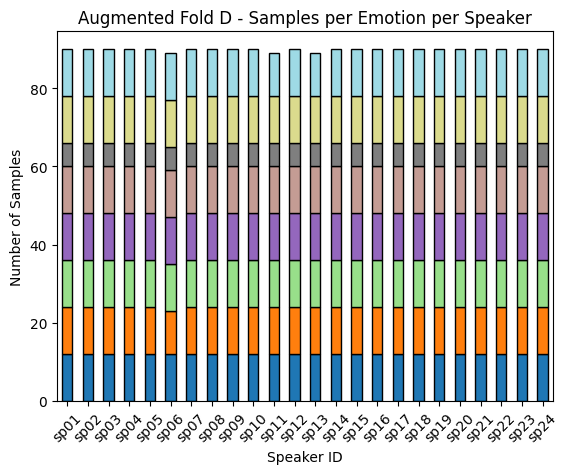

In [30]:
# Loop over each augmented fold
for fold_name in augmented_folds:
    y_aug = augmented_folds[fold_name]['y']
    emo_aug = augmented_folds[fold_name]['emo']
    # Create DataFrame for current fold
    df_fold = pd.DataFrame({
        'speaker_id': y_aug,
        'emotion': emo_aug})
    # Count samples per speaker per emotion
    counts = df_fold.groupby(['speaker_id', 'emotion']).size().unstack(fill_value=0)
    # Plot stacked bar chart
    plt.figure(figsize=(20, 5))
    counts.plot(kind='bar',
                stacked=True,
                colormap='tab20',
                edgecolor='black')
                #width=0.8)

    plt.title(f'Augmented Fold {fold_name.upper()} - Samples per Emotion per Speaker')
    plt.xlabel('Speaker ID')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    #plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend().remove()  # remove legend if too many emotions

    #plt.tight_layout()
    plt.show()

# TRAINING

# define the model

In [9]:
from tensorflow.keras.regularizers import l2
def create_cnn_model(input_shape, num_classes):
    weight_decay = 1e-4
    model = Sequential()
    # Conv3D Block 1
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    # TimeDistributed Conv2D Block 1
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    # Conv3D Block 2
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same',kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
    model.add(Dropout(0.2))
    # TimeDistributed Conv2D Block 2
    model.add(TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=l2(weight_decay))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Activation('elu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(3, 3), padding='same')))
    model.add(Dropout(0.2))
    # LSTM + Output
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax',kernel_regularizer=l2(weight_decay)))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=SGD(learning_rate=0.01, momentum=0.9),metrics=['accuracy'])
    return model

In [18]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 8, 64, 64, 16)  │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 64, 64, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 8, 64, 64, 16)  │         6,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 64, 64, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 32, 32, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 32, 32, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 4, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 4, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 4, 32, 32, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 4, 11, 11, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 11, 11, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 4, 11, 11, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 11, 11, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 4, 11, 11, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 11, 11, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 2, 6, 6, 128)   │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 2, 6, 6, 128)   │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 2, 6, 6, 128)   │             

 Total params: 1,046,792 (3.99 MB)

 Trainable params: 1,046,152 (3.99 MB)

 Non-trainable params: 640 (2.50 KB)

In [35]:
for i in augmented_folds:
    print(i)

for i in original_folds:
    print(i)

a
b
c
d
a
b
c
d


In [36]:
from sklearn.preprocessing import LabelEncoder

""" Combine all speaker IDs to fit LabelEncoder"""
all_speakers = np.concatenate([augmented_folds[f]['y'] for f in augmented_folds])
label_encoder = LabelEncoder()
label_encoder.fit(all_speakers)

""" Encode and update inside augmented_folds"""
for f in augmented_folds:
    augmented_folds[f]['y_encoded'] = label_encoder.transform(augmented_folds[f]['y'])

""" Encode and update inside original_folds"""
for f in original_folds:
    original_folds[f]['y_encoded'] = label_encoder.transform(original_folds[f]['y'])

In [37]:
for f in augmented_folds:
    X = augmented_folds[f]['X']
    augmented_folds[f]['X_expanded'] = X[..., np.newaxis]  
    
for f in original_folds:
    X = original_folds[f]['X']
    original_folds[f]['X_expanded'] = X[..., np.newaxis]

In [38]:
from time import sleep 
num_classes = len(label_encoder.classes_)

---
#
---
# **TRAINING ON ORIGINAL DATA**
---
#
---

In [45]:
accs = []

for fold in original_folds:
    print(f"\n=== Training on folds excluding '{fold}' and testing on '{fold}' ===")        
    ###################
    X_train = np.concatenate([original_folds[f]['X_expanded'] for f in original_folds if f != fold])
    y_train = np.concatenate([original_folds[f]['y_encoded'] for f in original_folds if f != fold])
    X_test = original_folds[fold]['X_expanded']
    y_test = original_folds[fold]['y_encoded']
    ###################
    model = create_cnn_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    ################### save model
    model_check = tf.keras.callbacks.ModelCheckpoint(filepath=f'/kaggle/working/rav_models/fold_{fold}.keras',monitor='val_accuracy',
                                                     mode='max',save_best_only=True,verbose=0)
    ###################Train
    model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[model_check, OneLineLogger(fold)], verbose=1)
    print(f'fold : {fold} is trained')
    sleep(5) 
    
    ################# Evaluate best model
    best_model = tf.keras.models.load_model(f'/kaggle/working/rav_models/fold_{fold}.keras')
    loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
    accs.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")


=== Training on folds excluding 'a' and testing on 'a' ===
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.0258 - loss: 3.2496 - val_accuracy: 0.0417 - val_loss: 3.4443
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.1220 - loss: 3.0470 - val_accuracy: 0.0444 - val_loss: 3.9605
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1810 - loss: 2.8478 - val_accuracy: 0.0417 - val_loss: 4.0790
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.2848 - loss: 2.4490 - val_accuracy: 0.0806 - val_loss: 3.4021
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4738 - loss: 1.8321 - val_accuracy: 0.2389 - val_loss: 2.4396
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5879 - loss: 1.4434 - val_accuracy: 0.2694 - val_loss: 2.5237
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6685 - loss: 1.1532 - val_accuracy: 0.4778 - val_loss: 1.7065
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 

# **METRICS**

In [46]:
accs

[0.9611111283302307,
 0.9638888835906982,
 0.9583333134651184,
 0.9583333134651184]

In [47]:
import numpy as np
import scipy.stats as stats

# Your 4-fold accuracy scores
accuracies = np.array(accs)

# Basic statistics
mean_acc = np.mean(accuracies)
std_dev = np.std(accuracies, ddof=1)  # ddof=1 for sample standard deviation
n = len(accuracies)

# 95% confidence interval using t-distribution
confidence = 0.95
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
margin_error = t_crit * (std_dev / np.sqrt(n))
ci_lower = mean_acc - margin_error
ci_upper = mean_acc + margin_error

# One-sample t-test against baseline (e.g., 0.95)
baseline = 0.95
t_stat, p_val = stats.ttest_1samp(accuracies, baseline)

# One-sided p-value (greater than baseline)
p_val_one_sided = p_val / 2 if t_stat > 0 else 1 - p_val / 2

# Print results
print(f"Mean Accuracy: {mean_acc:.5f}")
print(f"Standard Deviation: {std_dev:.5f}")
print(f"95% Confidence Interval: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"t-statistic vs baseline {baseline}: {t_stat:.3f}")
print(f"One-sided p-value: {p_val_one_sided:.4f}")

# Interpretation
if p_val_one_sided < 0.05:
    print("Result: Statistically significant improvement over baseline (p < 0.05).")
else:
    print("Result: Not statistically significant at the 0.05 level.")

Mean Accuracy: 0.96042
Standard Deviation: 0.00266
95% Confidence Interval: [0.95618, 0.96465]
t-statistic vs baseline 0.95: 7.833
One-sided p-value: 0.0022
Result: Statistically significant improvement over baseline (p < 0.05).


---
#
---
# **TRAINING ON AUGMENTED DATA**
---
#
---

In [ ]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

"""to avoid many lines in the console"""
class OneLineLogger(Callback):
    def __init__(self, fold_name):
        self.fold_name = fold_name

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        logs = logs or {}
        msg = (f"Fold {self.fold_name} — Epoch {epoch+1:03} — "
               f"Loss: {logs.get('loss', 0):.4f} — "
               f"Val Loss: {logs.get('val_loss', 0):.4f} — "
               f"Acc: {logs.get('accuracy', 0):.4f} — "
               f"Val Acc: {logs.get('val_accuracy', 0):.4f}")
        print(msg)

In [47]:
for fold in augmented_folds:
    print(f"\n=== Training on folds excluding '{fold}' and testing on '{fold}' ===")        
    ###################
    X_train = np.concatenate([augmented_folds[f]['X_expanded'] for f in augmented_folds if f != fold])
    y_train = np.concatenate([augmented_folds[f]['y_encoded'] for f in augmented_folds if f != fold])
    X_test = augmented_folds[fold]['X_expanded']
    y_test = augmented_folds[fold]['y_encoded']
    ###################
    model = create_cnn_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    # === Define model checkpoint
    model_check = tf.keras.callbacks.ModelCheckpoint(filepath=f'/kaggle/working/rav_aug_models/fold_{fold}.keras',monitor='val_accuracy',
                                                     mode='max',save_best_only=True,verbose=0)
    ###################
    model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[model_check, OneLineLogger(fold)], verbose=1)
    print(f'fold : {fold} is trained')
    print()
    ###################
    sleep(5)  # optional pause    
    ###################
    best_model = tf.keras.models.load_model(f'/kaggle/working/rav_aug_models/fold_{fold}.keras')
    loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
    accs.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

Fold d — Epoch 100 — Loss: 0.0291 — Val Loss: 0.0958 — Acc: 1.0000 — Val Acc: 0.9722
203/203 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 0.9722 - val_loss: 0.0958
fold : d is trained

Fold d Accuracy: 0.9806


# **METRICS**

In [117]:
accs

[0.9832480223359702, 0.9785946952070731, 0.9855612482533768, 0.976245924545878]

In [ ]:
accuracies = np.array(accs)
########################################
# Basic statistics
mean_acc = np.mean(accuracies)
std_dev = np.std(accuracies, ddof=1)  
########################################
n = len(accuracies)
# 95% confidence interval using t-distribution
confidence = 0.95
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
margin_error = t_crit * (std_dev / np.sqrt(n))
ci_lower = mean_acc - margin_error
ci_upper = mean_acc + margin_error
########################################
# One-sample t-test against baseline (e.g., 0.95)
baseline = 0.95
t_stat, p_val = stats.ttest_1samp(accuracies, baseline)

In [2]:
########################################
print(f"Mean Accuracy: {mean_acc:.5f}")
print(f"Standard Deviation: {std_dev:.5f}")
print(f"95% Confidence Interval: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value: {p_val:.4f}")

Mean Accuracy: 0.98091
Standard Deviation: 0.00425
95% Confidence Interval: [0.97415, 0.98768]
p-value: 0.0007


# confusion

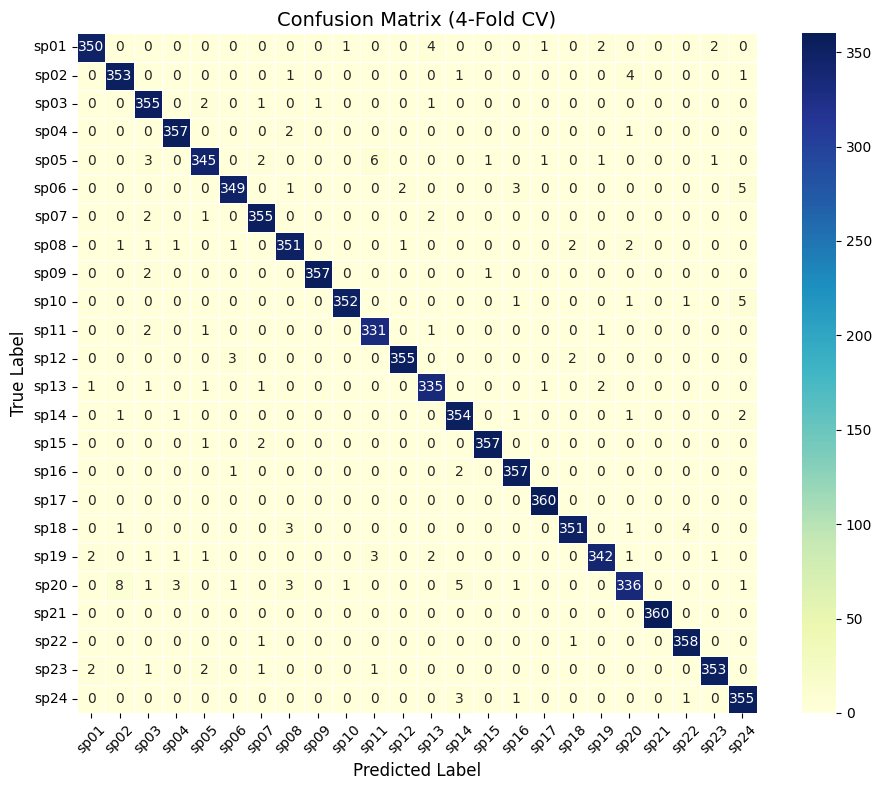

In [121]:
import seaborn as sns
cm = confusion_matrix(all_y_true, all_y_pred)
labels = label_encoder.classes_  
########################################
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=labels, yticklabels=labels, linewidths=0.5, square=True, cbar=True)
plt.title('Confusion Matrix (4-Fold CV)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# per emotion

In [100]:
from collections import defaultdict
########################################

emotion_accuracies = defaultdict(dict)  # {fold: {emotion: acc}}
for fold in fold_names:
    print(f"\n=== Training on folds excluding '{fold}' and testing on '{fold}' ===")    
    # === Prepare train and test sets
    X_train = np.concatenate([fold_data[f]['X_val'] for f in fold_names if f != fold])
    y_train = np.concatenate([fold_data[f]['y_val'] for f in fold_names if f != fold])
    emo_train = np.concatenate([fold_data[f]['emo_val'] for f in fold_names if f != fold])
    X_test = fold_data[fold]['X_val']
    y_test = fold_data[fold]['y_val']
    emo_test = fold_data[fold]['emo_val']
    # === Encode speaker labels
    y_train_enc = label_encoder.transform(y_train)
    y_test_enc = label_encoder.transform(y_test)
    # === Reshape inputs
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)
    # === Load pretrained model and freeze
    new_model = embeds_model(input_shape=X_train.shape[1:])
    pretrained_model = load_model(f'/kaggle/working/ravdess_models/{fold}.keras')
    for i, layer in enumerate(pretrained_model.layers[:-1]): 
        new_model.layers[i].set_weights(layer.get_weights())
    for layer in new_model.layers[:]:
        layer.trainable = False
    # === Compile and extract embeddings
    new_model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
    feat_train = new_model.predict(X_train)
    feat_test = new_model.predict(X_test)
    # === Train SVM
    svm = SVC(kernel='linear')
    svm.fit(feat_train, y_train_enc)
    y_pred = svm.predict(feat_test)
    # === Per-emotion accuracy
    unique_emotions = np.unique(emo_test)
    for emo_label in unique_emotions:
        indices = np.where(emo_test == emo_label)[0]
        if len(indices) == 0:
            continue
        acc = accuracy_score(y_test_enc[indices], y_pred[indices])
        emotion_accuracies[fold][emo_label] = acc


=== Training on folds excluding 'a' and testing on 'a' ===
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== Training on folds excluding 'b' and testing on 'b' ===
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== Training on folds excluding 'c' and testing on 'c' ===
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

=== Training on folds excluding 'd' and testing on 'd' ===
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [122]:
df = pd.DataFrame(emotion_accuracies).T 
print(df.round(3))

   angry   calm  disgust  fearful  happy  neutral    sad  surprised
a  0.955  0.993    0.965    0.997  0.990    1.000  0.983      0.993
b  0.958  0.986    0.976    0.993  0.965    0.993  0.986      0.979
c  0.976  0.996    0.979    0.990  0.986    0.993  0.990      0.978
d  0.965  0.982    0.951    0.986  0.986    0.993  0.972      0.982


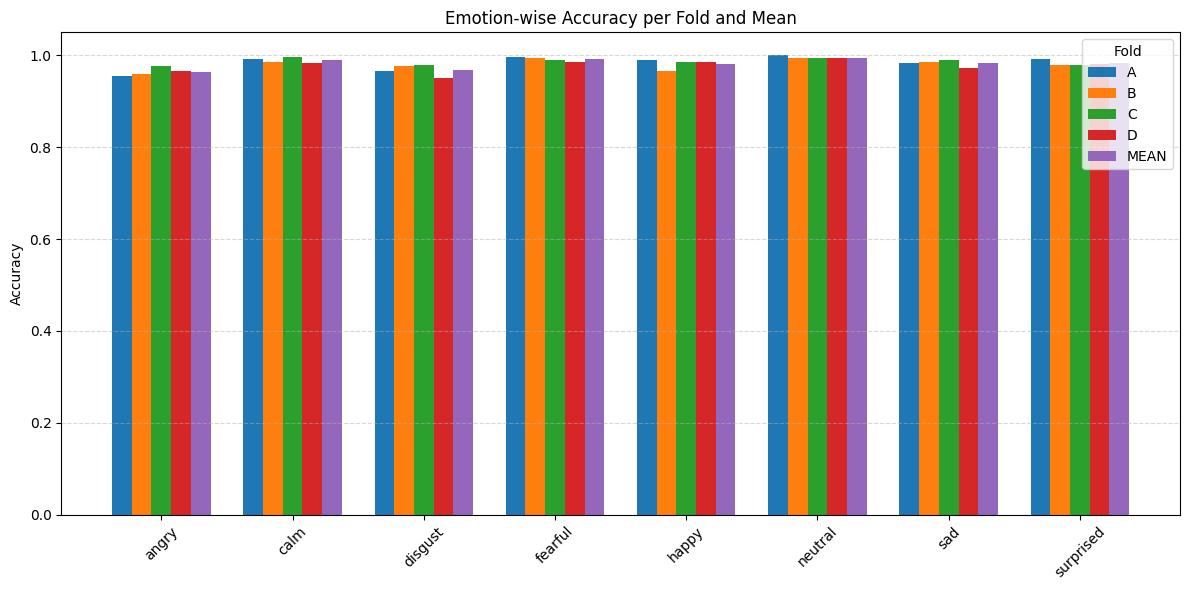

In [125]:
df.loc['mean'] = df.mean()
emotions = df.columns
folds = df.index
x = np.arange(len(emotions)) 
width = 0.15  
########################################
plt.figure(figsize=(12, 6))
for i, fold in enumerate(folds):
    plt.bar(x + i * width, df.loc[fold], width, label=fold.upper())
plt.xticks(x + width * (len(folds)-1)/2, emotions, rotation=45)
plt.ylabel('Accuracy')
plt.title('Emotion-wise Accuracy per Fold and Mean')
plt.ylim(0, 1.05)
plt.legend(title='Fold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [126]:
mean_accuracies = df.mean()
mean_accuracies

angry        0.963542
calm         0.989474
disgust      0.967882
fearful      0.991319
happy        0.981771
neutral      0.994792
sad          0.982639
surprised    0.982965
dtype: float64

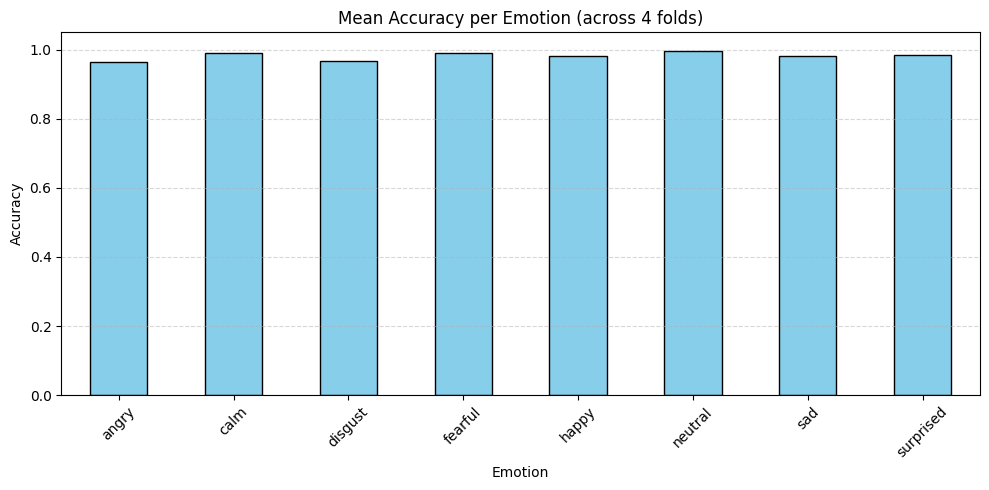

In [108]:
plt.figure(figsize=(10, 5))
mean_accuracies.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mean Accuracy per Emotion (across 4 folds)')
plt.ylabel('Accuracy')
plt.xlabel('Emotion')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()